In [1]:
from os import environ
from collections import Counter
import random
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from librosa import display
from wordcloud import WordCloud
from PIL import Image

from medleydb.utils import (get_instrument_stems, get_instruments_list, get_instruments_dict, 
                            get_instrument_tracks, get_track_instruments, get_instrument_ratio as medley_ratio
)

#### Create the environnement variables

In [ ]:
#%env MEDLEYDB_PATH=path/to/audio
#%env METADATA_PATH=path/to/metadata

In [ ]:
# working directory
wd_path = Path.cwd()

data_path = wd_path.joinpath("data") # data directory containing the metadata.csv

image_path = wd_path.joinpath('images') # images from the data visualizations

metadata_path = Path(environ['METADATA_PATH']) # medleyDB repo metadata path

audio_path = Path(environ['MEDLEYDB_PATH']) # medleyDB audio files path

activation_path = metadata_path.parent.joinpath("Annotations", "Activation_Confidence", "all") # activation path

print("wd: {},\ndata: {},\nmedleydb metadata: {},\nactivation data: {},\naudio: {},\nimages: {}".format(
    wd_path, data_path, metadata_path, activation_path, audio_path, image_path))

### Listing the audio files of the dataset

In [4]:
audio_files = [a.name for a in audio_path.iterdir() if a.is_dir()]
audio_files[:5]

['AClassicEducation_NightOwl',
 'AimeeNorwich_Child',
 'AimeeNorwich_Flying',
 'AlexanderRoss_GoodbyeBolero',
 'AlexanderRoss_VelvetCurtain']

### Listing the metadata files (yaml)

In [ ]:
metadata_files = [m for m in metadata_path.glob('*.yaml')]
metadata_files[:5]

In [6]:
metadata_filenames = [m.name.split("_METADATA")[0] for m in metadata_files]
metadata_filenames[:5]

['AcDc_BackInBlack',
 'AClassicEducation_NightOwl',
 'Adele_SomeoneLikeYou',
 'Aerosmith_LoveInAnElevator',
 'AHa_TakeOnMe']

In [7]:
match = [m for m in metadata_files if m.name.split("_METADATA")[0] in audio_files]

In [8]:
len(match)

196

### Reading the dataset created from the audio metadata files
To recreate the file, use the script below

In [9]:
metadata_df = pd.read_csv(data_path.joinpath("metadata.csv"), index_col=0)

### Script to create the dataframe from the yaml metadata files

````python
metadata_df = pd.DataFrame()

for f in match:
    with open(f, 'r') as stream:
        m = pd.json_normalize(yaml.load(stream, Loader=yaml.FullLoader), max_level=0)
    metadata_df = metadata_df.append(m, ignore_index=True)

metadata_df.to_csv(data_path.joinpath("metadata.csv"))
````

In [10]:
metadata_df.head()

album               artist                 composer  \
0  Shaking Through Volume 2  A Classic Education  ['A Classic Education']   
1                       NaN        Aimee Norwich        ['Aimee Norwich']   
2                       NaN        Aimee Norwich        ['Aimee Norwich']   
3                       NaN       Alexander Ross       ['Alexander Ross']   
4                       NaN       Alexander Ross       ['Alexander Ross']   

  excerpt              genre has_bleed instrumental  \
0      no  Singer/Songwriter        no           no   
1      no  Singer/Songwriter        no           no   
2      no         World/Folk        no          yes   
3      no  Singer/Songwriter        no           no   
4      no  Singer/Songwriter        no           no   

                          mix_filename              origin  \
0   AClassicEducation_NightOwl_MIX.wav   Weathervane Music   
1           AimeeNorwich_Child_MIX.wav  Independent Artist   
2          AimeeNorwich_Flying_MIX.wav  Independent Artist   
3  AlexanderRoss_GoodbyeBolero_MIX.wav  Independent Artist   
4  AlexanderRoss_VelvetCurtain_MIX.wav  Independent Artist   

                           producer                          raw_dir  \
0                 ['Andy Williams']   AClassicEducation_NightOwl_RAW   
1  ['Aimee Norwich & Senem Pirler']           AimeeNorwich_Child_RAW   
2  ['Aimee Norwich & Senem Pirler']          AimeeNorwich_Flying_RAW   
3                  ['Mike Tierney']  AlexanderRoss_GoodbyeBolero_RAW   
4                  ['Mike Tierney']  AlexanderRoss_VelvetCurtain_RAW   

                            stem_dir  \
0   AClassicEducation_NightOwl_STEMS   
1           AimeeNorwich_Child_STEMS   
2          AimeeNorwich_Flying_STEMS   
3  AlexanderRoss_GoodbyeBolero_STEMS   
4  AlexanderRoss_VelvetCurtain_STEMS   

                                               stems           title  version  \
0  {'S01': {'component': 'bass', 'filename': 'ACl...       Night Owl      1.2   
1  {'S01': {'component': '', 'filename': 'AimeeNo...           Child      1.2   
2  {'S01': {'component': '', 'filename': 'AimeeNo...          Flying      1.2   
3  {'S01': {'component': '', 'filename': 'Alexand...  Goodbye Bolero      1.2   
4  {'S01': {'component': 'melody', 'filename': 'A...  Velvet Curtain      1.2   

                                        website  
0  ['www.shakingthrough.com/aclassiceducation']  
1                      ['www.aimeenorwich.com']  
2                      ['www.aimeenorwich.com']  
3                                            []  
4                                            []

### Listing all unique instruments

In [11]:
instruments_list = get_instruments_list(metadata_df["stems"])

instruments_list[:10]

['accordion',
 'string section',
 'double bass',
 'electric bass',
 'horn section',
 'trumpet section',
 'oboe',
 'tenor saxophone',
 'fx/processed sound',
 'electric piano']

### Creating a dictionnary of instrument, useful to rename the audio files in the preprocessing

In [12]:
instruments_dict = get_instruments_dict(instruments_list)

for i, (k, v) in enumerate(instruments_dict.items()):
    if i == 10:
        break
    print("{}: {}".format(k, v))

accordion: accordion
string section: string_section
double bass: double_bass
electric bass: electric_bass
horn section: horn_section
trumpet section: trumpet_section
oboe: oboe
tenor saxophone: tenor_saxophone
fx/processed sound: fx_processed_sound
electric piano: electric_piano


### Counting the occurences of instruments

In [13]:
# for each track, read the stems intruments and add to instrument counter
instrument_counter = {}

for track in metadata_df["stems"]:
    # get the instrument list of a track
    track_instruments = get_track_instruments(track)
    
    # for each instrument of the list increment the instrument counter
    for i in track_instruments:
        if i in instrument_counter:
            instrument_counter[i] += 1
        else:
            instrument_counter[i] = 1

instruments_df = pd.DataFrame.from_dict(instrument_counter, orient="index", columns=["Occurence"]).sort_values(by="Occurence", ascending=False)

instruments_df.head()

Occurence
drum set                     106
electric bass                 84
piano                         72
clean electric guitar         53
male singer                   50

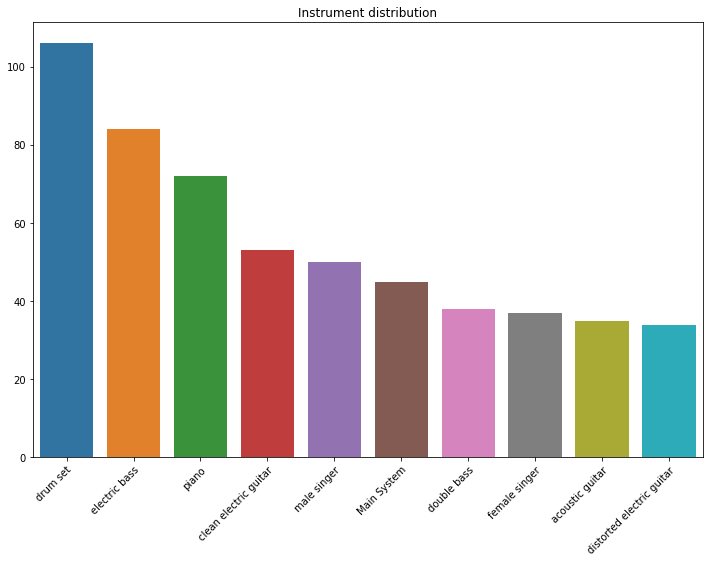

In [14]:
top_instruments = instruments_df[:10].T

fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(data=top_instruments, ax=ax)
ax.set_title("Instrument distribution")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()
#fig.savefig(image_path.joinpath('dist_instrument.png'), transparent=False, dpi=80, bbox_inches="tight")

### Wordcloud of instruments

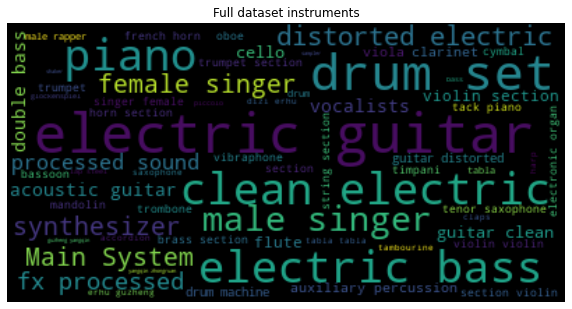

In [15]:
full_instruments_list = []
for stems in metadata_df["stems"]:
    stems = eval(stems)
    for s in stems.values():
        full_instruments_list.append(s["instrument"])

text = " ".join(full_instruments_list)

wordcloud = WordCloud(max_font_size=40).generate(text)

fig, ax = plt.subplots(figsize=(10, 20))
ax.imshow(wordcloud, interpolation="bilinear")
ax.set_title("Full dataset instruments")
ax.axis("off")

plt.show()
#fig.savefig(image_path.joinpath('instr_word_clouds.png'), transparent=False, dpi=80, bbox_inches="tight")

### Using a mask to create a word cloud

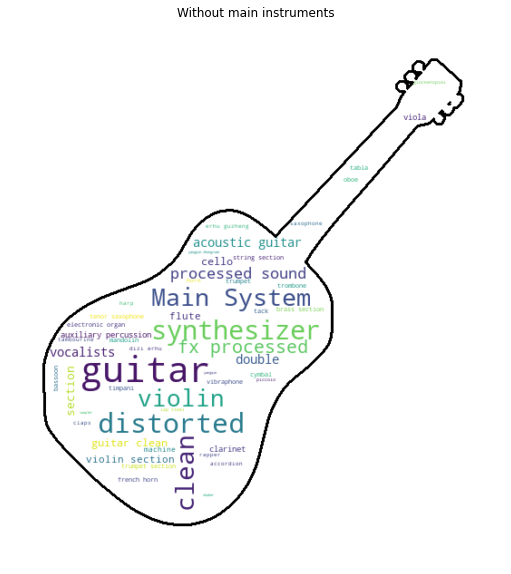

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))

STOP_WORDS = ["drum", "set", "electric", "bass", "piano", "male", "female", "singer"]

guitar_mask = np.array(Image.open(image_path.joinpath("guitar_mask.png")))

wordcloud = WordCloud(background_color="white", max_font_size=40, stopwords=STOP_WORDS, mask=guitar_mask, contour_width=3, contour_color='black').generate(text)

ax.imshow(wordcloud, interpolation="bilinear")
ax.set_title("Without main instruments")
ax.axis("off")

plt.show()
#fig.savefig(image_path.joinpath('guitar_word_cloud.png'), transparent=False, dpi=80, bbox_inches="tight")

### Wordcloud of genres

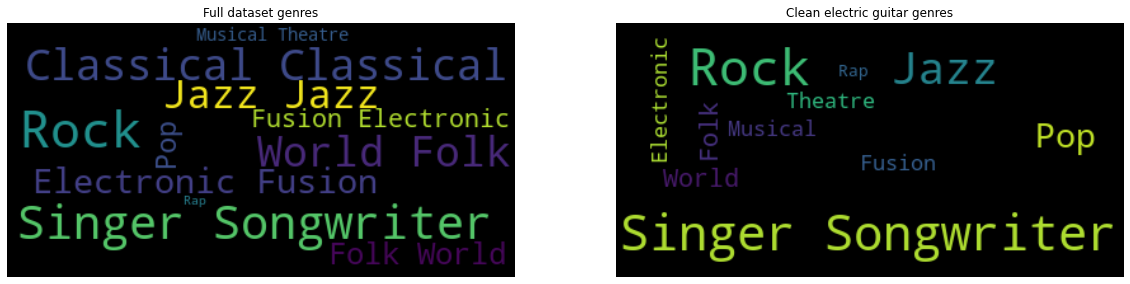

In [17]:
text = " ".join(metadata_df["genre"].values)

wordcloud = WordCloud(max_font_size=40).generate(text)

fig, axs = plt.subplots(1, 2, figsize=(20, 20))

axs[0].imshow(wordcloud, interpolation="bilinear")
axs[0].set_title("Full dataset genres")
axs[0].axis("off")

clean_el_guitar_tracks = get_instrument_tracks(get_instrument_stems(metadata_df["stems"], "clean electric guitar"), "clean electric guitar")
text = ""
for genre, track in zip(metadata_df["genre"], metadata_df["stem_dir"]):
    if track.split("_STEM")[0] in clean_el_guitar_tracks:
        text += " " + genre

wordcloud = WordCloud(max_font_size=40).generate(text)
axs[1].imshow(wordcloud, interpolation="bilinear")
axs[1].set_title("Clean electric guitar genres")
axs[1].axis("off")

plt.show()

### Listing the TRACKS containing STEMS with a specific instrument

Here `clean electric guitar`

In [18]:
target_instrument = "clean electric guitar"

clean_el_guitar_stems = get_instrument_stems(metadata_df["stems"], target_instrument)

clean_el_guitar_stems[:10]

['AClassicEducation_NightOwl_STEM_05.wav',
 'AimeeNorwich_Child_STEM_03.wav',
 'AimeeNorwich_Flying_STEM_04.wav',
 'AimeeNorwich_Flying_STEM_05.wav',
 'AlexanderRoss_GoodbyeBolero_STEM_02.wav',
 'AlexanderRoss_GoodbyeBolero_STEM_03.wav',
 'AlexanderRoss_VelvetCurtain_STEM_02.wav',
 'AlexanderRoss_VelvetCurtain_STEM_03.wav',
 'AlexanderRoss_VelvetCurtain_STEM_10.wav',
 'AmarLal_Rest_STEM_01.wav']

### Listing the TRACKS containing a specific instrument

In [19]:
clean_el_guitar_tracks = get_instrument_tracks(clean_el_guitar_stems, target_instrument)
clean_el_guitar_tracks[:10]

['AClassicEducation_NightOwl',
 'AimeeNorwich_Child',
 'AimeeNorwich_Flying',
 'AlexanderRoss_GoodbyeBolero',
 'AlexanderRoss_VelvetCurtain',
 'AmarLal_Rest',
 'Auctioneer_OurFutureFaces',
 'CelestialShore_DieForUs',
 'ChrisJacoby_BoothShotLincoln',
 'ClaraBerryAndWooldog_AirTraffic']

### Clean electric guitar dataset statistics

In [ ]:
# lenghts of the tracks
track_lengths = []
for track in clean_el_guitar_tracks:
    track_path = audio_path.joinpath(track, track + "_MIX.wav")
    try:
        track_lengths.append(librosa.get_duration(filename=track_path))
    except:
        print(f"Error reading: {track_path}")
print()     
# number of tracks
print(f"Number of tracks containing '{target_instrument}': {len(clean_el_guitar_tracks)}")    
print(f"Total duration: {sum(track_lengths)/3600:.2f} hours")

### Focusing on the COMPONENT value of the STEMS

The `component` value indicates if the stem is a melody, a bass line or a accompaniment track

In [21]:
target_stems_component = []
for stem in metadata_df["stems"]:
    stem = eval(stem)
    for s in stem.values():
        if s["instrument"] == target_instrument:
            target_stems_component.append(s["component"])

component_count = Counter(target_stems_component)
print(f"{target_instrument} stems components:\n{component_count['melody']} melodies, {component_count['']} accompaniment tracks.")

clean electric guitar stems components:
29 melodies, 51 accompaniment tracks.


In [23]:
celg_component_df = pd.DataFrame(component_count.values(), index=["accompaniment", "melody"], columns=["Count"])
celg_component_df

Count
accompaniment     51
melody            29

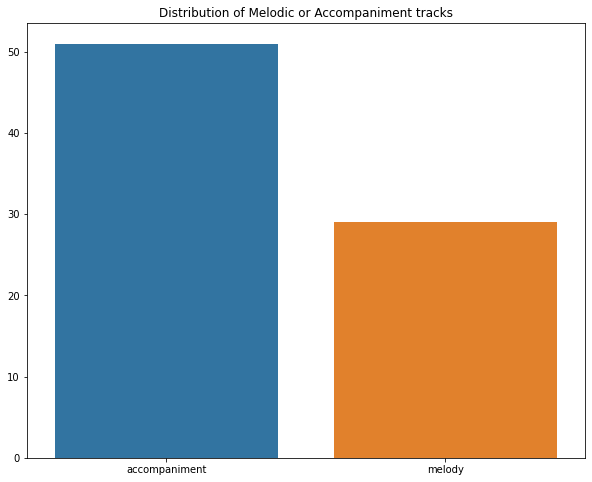

In [24]:
fig, ax = plt.subplots(figsize=(10,8))

sns.barplot(data=celg_component_df.T, ax=ax)
ax.set_title('Distribution of Melodic or Accompaniment tracks')

plt.show()

### Focusing on whether or not the TRACKS  has bleed
Since all the stems audio sources were not totally isolated from each other during the recording

In [25]:
clean_el_guitar_mix = [t + "_MIX.wav" for t in clean_el_guitar_tracks]

has_bleed = []
for m in clean_el_guitar_mix:
    has_bleed.append(metadata_df[metadata_df["mix_filename"] == m].iloc[0]["has_bleed"])

has_bleed_count = Counter(has_bleed)

print(f"{target_instrument} tracks:\n{has_bleed_count['yes']} have bleed, {has_bleed_count['no']} don't.")

clean electric guitar tracks:
14 have bleed, 39 don't.


In [26]:
celg_has_bleed_df = pd.DataFrame(has_bleed_count.values(), index=["No", "Yes"], columns=["Count"])
celg_has_bleed_df

Count
No      39
Yes     14

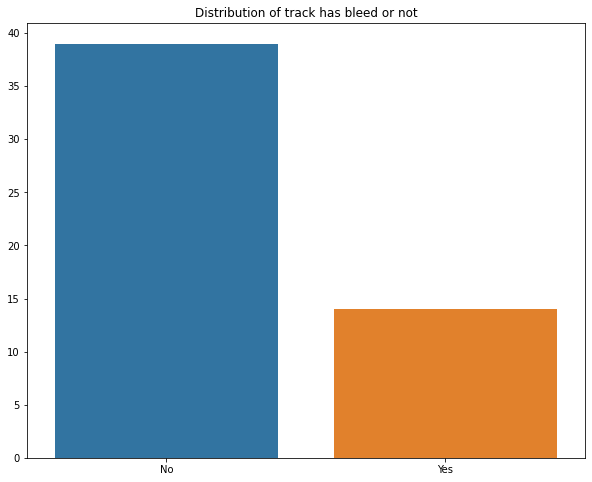

In [27]:
fig, ax = plt.subplots(figsize=(10,8))

sns.barplot(data=celg_has_bleed_df.T, ax=ax)
ax.set_title('Distribution of track has bleed or not')

plt.show()

### Spectrum modeling with the librosa library

### Visualization of 3 random electric guitar tracks

In [28]:
# We get 2 lists to be able to compare the spectra of these 2 types of guitars
electric_stems = get_instrument_stems(metadata_df["stems"], instrument_name = 'clean electric guitar')
acoustic_stems = get_instrument_stems(metadata_df["stems"], instrument_name = 'acoustic guitar')

In [29]:
# picking randomly 3 tracks
electric_choice = random.choices(electric_stems, k = 3)
print("The 3 tracks are : ", electric_choice)

The 3 tracks are :  ['SecretMountains_HighHorse_STEM_05.wav', 'MusicDelta_Reggae_STEM_03.wav', 'SasquatchConnection_HolyClamsBatman_STEM_02.wav']


In [30]:
# Recover the path of the track randomly chosen
clean_sampling_electric = [s.split("_STEM")[0] for s in electric_choice]
celg_tracks = [Path.joinpath(audio_path, s, f"{s}_STEMS", e) for e, s in zip(electric_choice, clean_sampling_electric)]

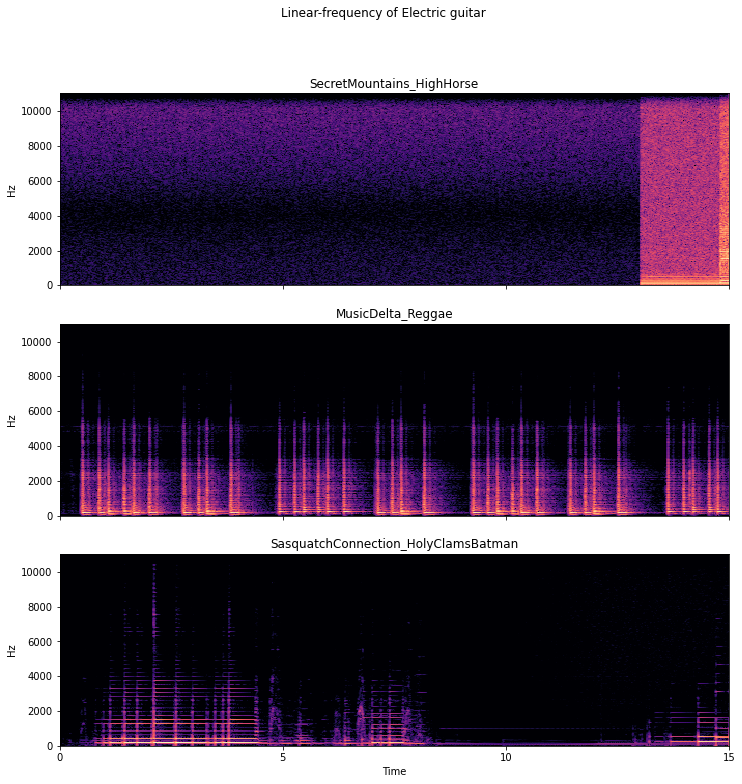

In [31]:
# Model 3 spectra of electric guitar randomly
fig, axs = plt.subplots(nrows=len(celg_tracks), figsize=(12, 12), sharex=True)
for t, ax in zip(celg_tracks, axs) :
    wav, sr = librosa.load(t, duration=15)
    db_array = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
    librosa.display.specshow(db_array, y_axis='linear', x_axis='time', sr=sr, ax=ax)
    ax.set_title(t.name.split("_STEM")[0])
    ax.label_outer()
fig.suptitle("Linear-frequency of Electric guitar")
plt.show()

### Visualization of 3 random acoustic guitar tracks

In [32]:
# We do the same procedure for acoustic guitar
acoustic_choice = random.choices(acoustic_stems, k = 3)
print("The 3 tracks are : ", acoustic_choice)

The 3 tracks are :  ['LittleTybee_TheAlchemist_STEM_01.wav', 'AlexanderRoss_VelvetCurtain_STEM_01.wav', 'HezekiahJones_BorrowedHeart_STEM_01.wav']


In [33]:
clean_sampling_acoustic = [s.split("_STEM")[0] for s in acoustic_choice]
acoustic_tracks = [Path.joinpath(audio_path, s, f"{s}_STEMS", e) for e, s in zip(acoustic_choice, clean_sampling_acoustic)]

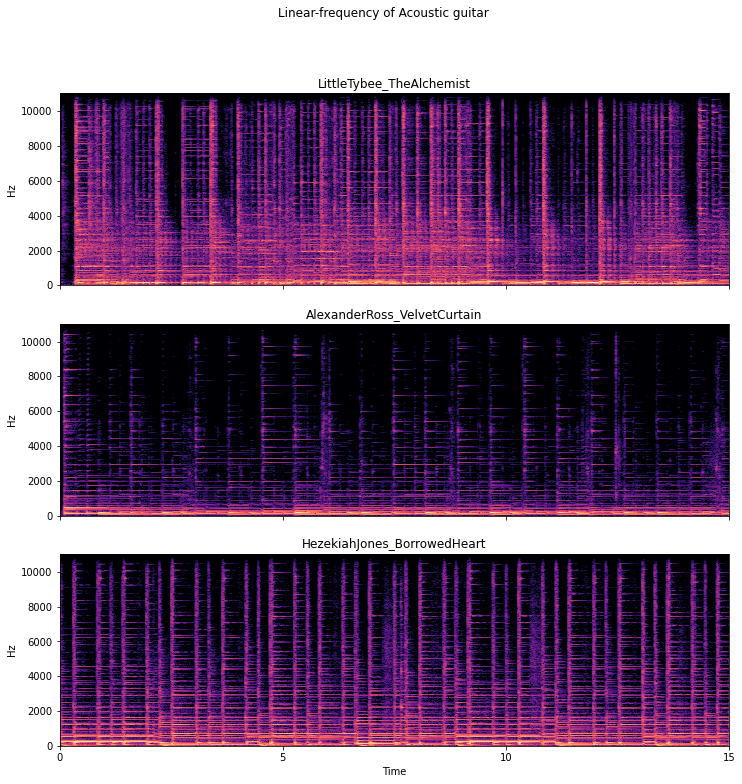

In [34]:
fig, axs = plt.subplots(nrows=len(acoustic_tracks), figsize=(12, 12), sharex=True)
for t, ax in zip(acoustic_tracks, axs) :
    wav, sr = librosa.load(t, duration=15)
    db_array = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
    librosa.display.specshow(db_array, y_axis='linear', x_axis='time', sr=sr, ax=ax)
    ax.set_title(t.name.split("_STEM")[0])
    ax.label_outer()
fig.suptitle("Linear-frequency of Acoustic guitar")
plt.show()

### Decomposition of a mix

In [35]:
def get_stems(track):
    """
    Returns the stems list and the instrument list of track
    """
    # recover the path of the track
    track_path = f"{track}_STEMS"
    stems_path = audio_path.joinpath(track, track_path)

    # stems list
    stems_list = [f for f in stems_path.glob('**/*.wav')]

    track_stems = metadata_df.query(f"stem_dir == '{track_path}'")["stems"].iloc[0]
    track_stems = eval(track_stems)   

    # instrument list
    instrument_list = [s["instrument"] for s in track_stems.values()]
    
    return stems_list, instrument_list

In [36]:
# plot audio samples
def get_audio(track):
    """
    Plot the the stems of track
    """
    stems_list, instrument_list = get_stems(track)
    plt.figure(figsize=(20,10))

    for i, s in enumerate(stems_list):
        audio, _ = librosa.load(s)
        plt.plot(audio[0:1500], label = instrument_list[i])
        plt.legend(framealpha=1, frameon=True)

    plt.ylabel("Amplitude")
    plt.xlabel("Time (ms)")
    plt.title("Sample Wav")
    plt.show()

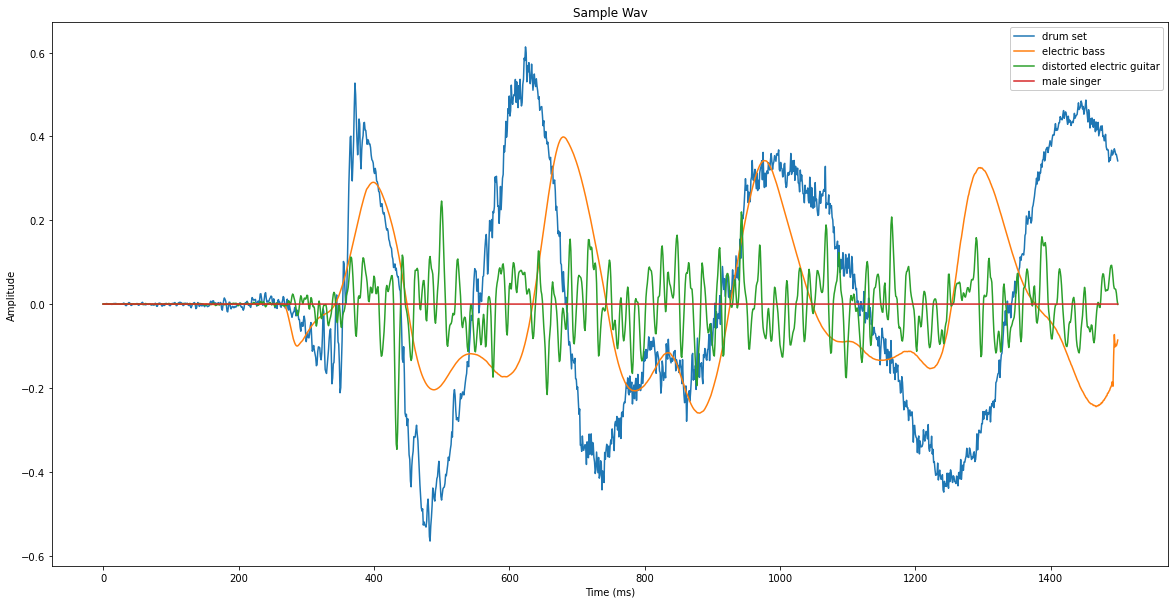

In [37]:
get_audio('MusicDelta_Hendrix')

In [38]:
def get_linear_frequency(track):
    """
    Plot the mix and the stems composing the mix
    """
    stems_list, instruments_list = get_stems(track)
    stems_path_mix = audio_path.joinpath(track, track + "_MIX.wav")

    wav, sr = librosa.load(stems_path_mix, duration=30)
    fig, ax = plt.subplots(figsize=(20,10))
    db_array = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
    img = librosa.display.specshow(db_array, y_axis='linear', x_axis='time', sr=sr, ax=ax)
    ax.set(title='Linear-frequency power spectrogram of mix')
    ax.label_outer()
    plt.show()

    fig, axs = plt.subplots(nrows=1, ncols=len(instruments_list), figsize=(20,10), sharey= True)

    for i, ax in enumerate(axs) :
        wav, sr = librosa.load(stems_list[i], duration=30)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
        img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax)
        ax.set_title(instruments_list[i])
        ax.label_outer()
        fig.suptitle('Linear fraquency of : ')

    plt.show()   

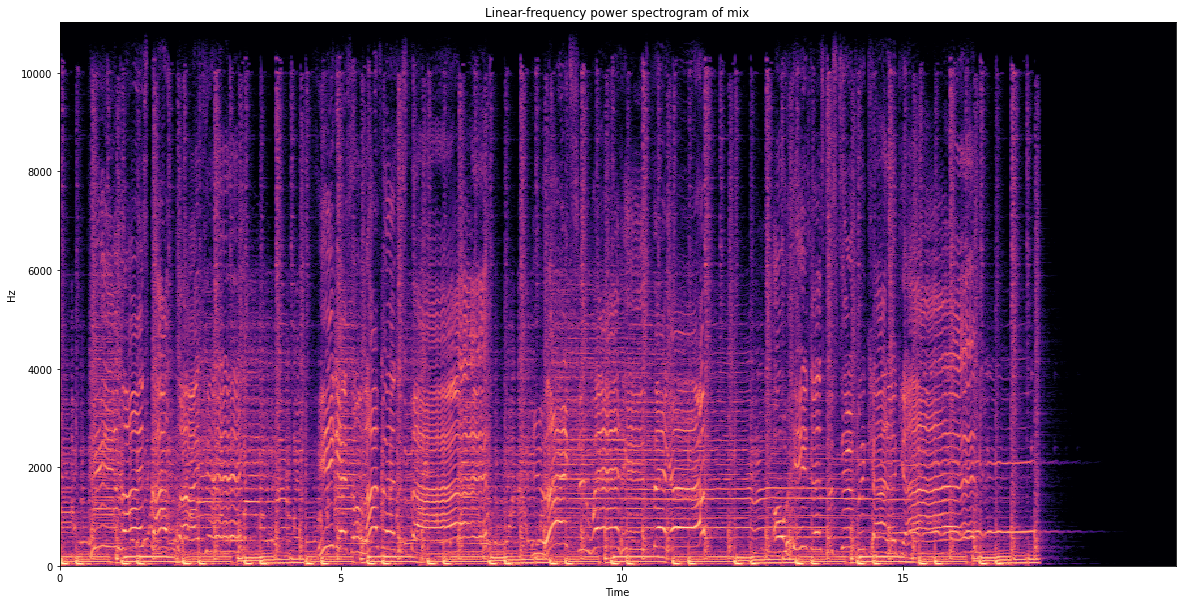

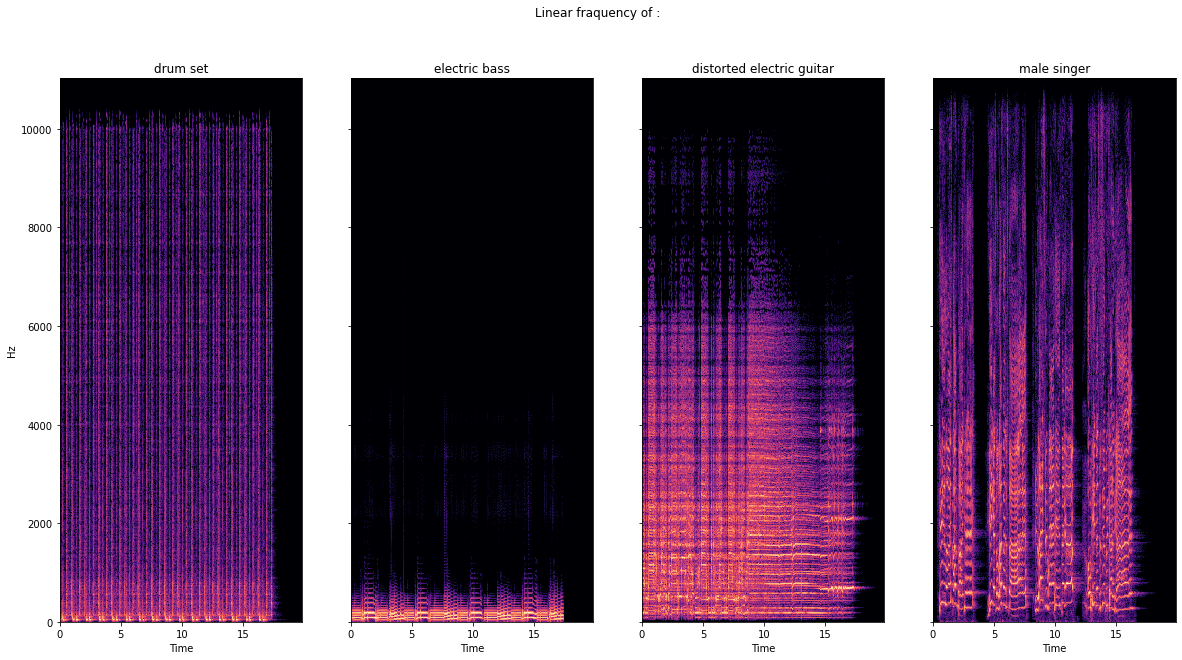

In [39]:
get_linear_frequency('MusicDelta_Hendrix')

### Presence ratio of the instruments


In [40]:
electric_track_activations, _ = medley_ratio(metadata_df["stems"], activation_path, "clean electric guitar")
acoustic_track_activations, _ = medley_ratio(metadata_df["stems"], activation_path, "acoustic guitar")
piano_track_activations, _ = medley_ratio(metadata_df["stems"], activation_path, "piano")
drums_track_activations, _ = medley_ratio(metadata_df["stems"], activation_path, "drum set")

print(f"electric clean guitar mean presence: {np.mean(list(electric_track_activations.values())):.2%}")
print(f"acoustic guitar mean presence: {np.mean(list(acoustic_track_activations.values())):.2%}")
print(f"piano mean presence: {np.mean(list(piano_track_activations.values())):.2%}")
print(f"drums mean presence: {np.mean(list(drums_track_activations.values())):.2%}")

electric clean guitar mean presence: 72.38%
acoustic guitar mean presence: 79.38%
piano mean presence: 81.11%
drums mean presence: 86.47%


In [41]:
# stems with less than 40% of presence to check audio
for k, v in acoustic_track_activations.items():
    if v < 0.4:
        print(f"{v:0.2%}")
        stems = get_instrument_stems(metadata_df["stems"], "acoustic guitar")
        print(*[s for s in stems if s.split("_STEM")[0] == k])

25.34%
DeadMilkmen_PrisonersCinema_STEM_01.wav
9.62%
FamilyBand_Again_STEM_04.wav
34.52%
JoelHelander_ExcessiveResistancetoChange_STEM_09.wav
9.48%
KarimDouaidy_Hopscotch_STEM_02.wav KarimDouaidy_Hopscotch_STEM_06.wav
26.39%
TheKitchenettes_Alive_STEM_02.wav
27.19%
TheSoSoGlos_Emergency_STEM_09.wav
